In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
#import pydicom
#import skimage

## fix random_state for reproducibility
random_state = 42

In [25]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('./project1_images/Data_Entry_2017.csv')
all_xray_df.sample(3, random_state=random_state)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,0.143,NaN
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,65,M,AP,2500,2048,0.168,0.168,NaN
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,0.143,NaN


In [3]:
all_xray_df = all_xray_df.drop(columns= ['Unnamed: 11'])
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')

In [4]:
data_sample = pd.read_csv('sample_labels.csv')
data_sample.sample(3, random_state=random_state)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2146,00011065_007.png,No Finding,7,11065,066Y,M,PA,2992,2991,0.143,0.143
1879,00009892_001.png,No Finding,1,9892,062Y,F,PA,2992,2991,0.143,0.143
346,00001836_076.png,Mass|Nodule,76,1836,050Y,F,AP,2500,2048,0.168,0.168


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia.

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

In [22]:
data_sample_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('./project1_images', 'images*', '*', '*.png'))}
data_sample['path'] = data_sample['Image Index'].map(data_sample_paths.get)
data_sample.sample(3, random_state=random_state)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2146,00011065_007.png,No Finding,7,11065,066Y,M,PA,2992,2991,0.143,0.143,None
1879,00009892_001.png,No Finding,1,9892,062Y,F,PA,2992,2991,0.143,0.143,None
346,00001836_076.png,Mass|Nodule,76,1836,050Y,F,AP,2500,2048,0.168,0.168,./project1_images\images_002\images\00001836_0...


Also, **describe your findings and how will you set up the model training based on the findings.**

In [6]:
## EDA
# Todo 

### Examine the distributions of the findings

In [7]:
# split the labels to identify individual diseases
labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [label for label in labels if label != 'No Finding']

# add each label as a column to the dataframe and assign 1 if present and 0 otherwise
for label in labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
    print('%s: %d'%(label, int(all_xray_df[label].sum())))

Atelectasis: 11559
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2303
Effusion: 13317
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19894
Mass: 5782
Nodule: 6331
Pleural_Thickening: 3385
Pneumonia: 1431
Pneumothorax: 5302


[Text(0,0.5,'Number of Images with findings')]

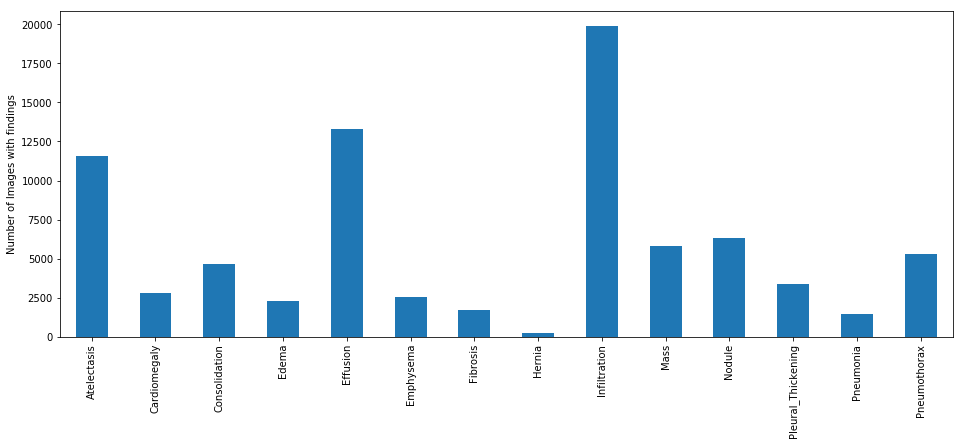

In [8]:
# Visualizing the counts of each finding
plt.figure(figsize=(16,6))
ax = all_xray_df[labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with findings')

### Demographic distribution of findings

#### Distribution by Gender

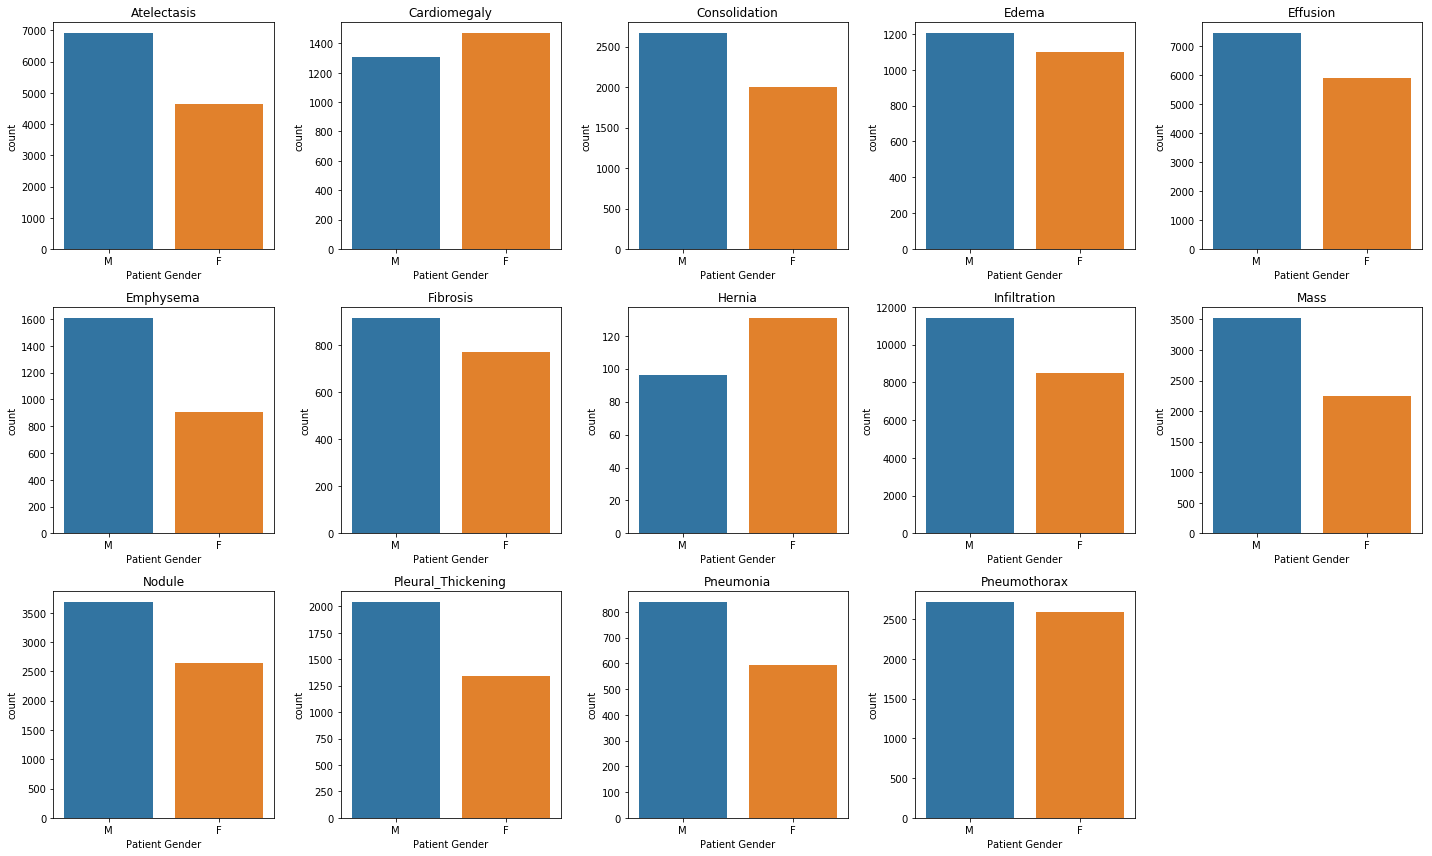

In [9]:
fig = plt.subplots(figsize = (20, 12))
for ind, label in enumerate(labels):
    plt.subplot(3, 5, ind+1)
    #ax = all_xray_df[all_xray_df[label] == 1.0]['Patient Gender'].value_counts().plot(kind='bar')
    plt.subplots_adjust(hspace = 1.0)
    ax = sns.countplot(x='Patient Gender',data = all_xray_df[all_xray_df[label] == 1], order=['M', 'F'])#, hue='Patient Gender')
    plt.title(label)
    plt.tight_layout()

#### Distribution by age

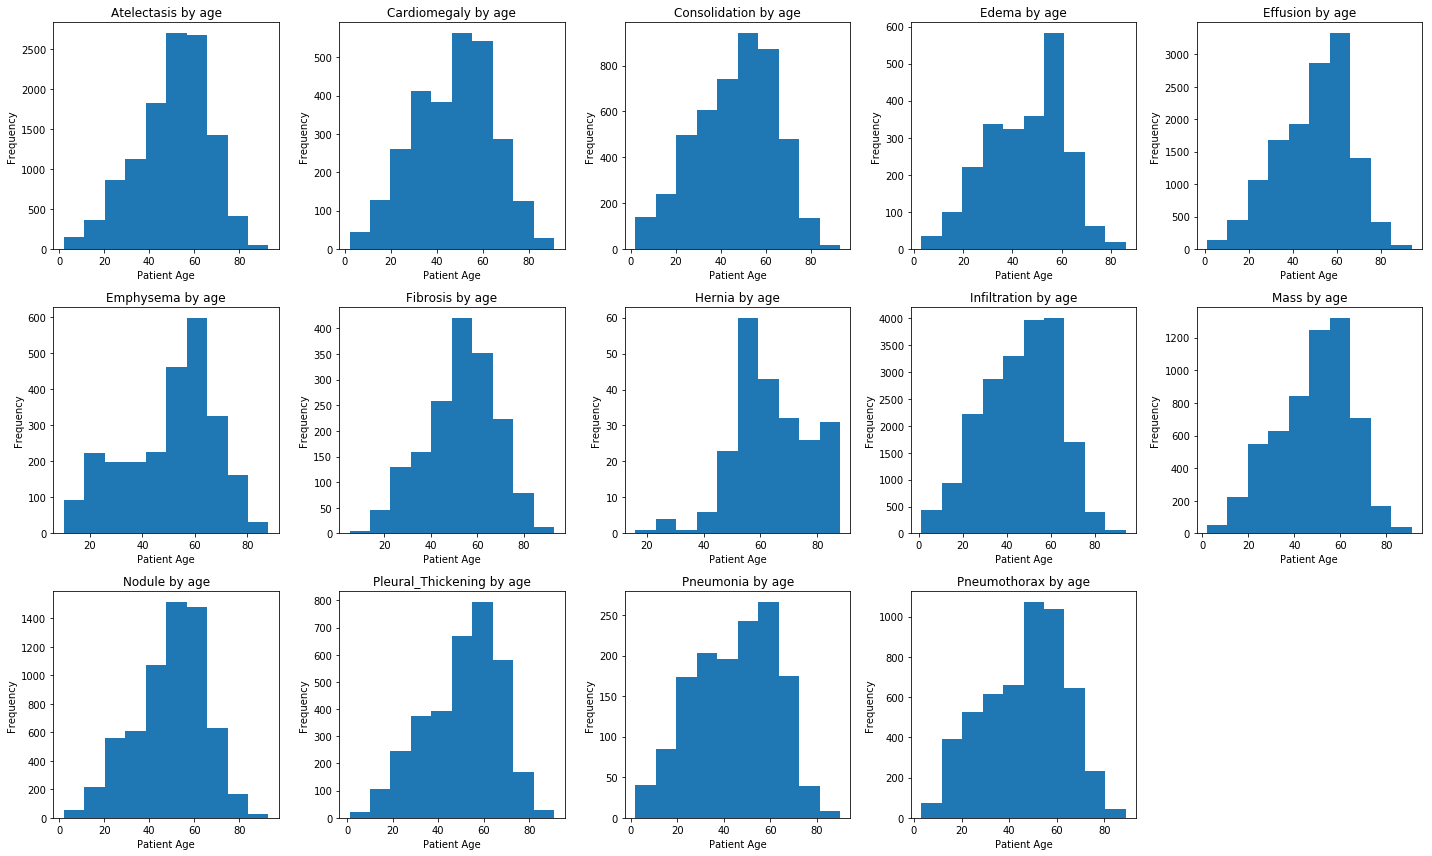

In [10]:
# I adopt a cut-off of 140 years for age
age_mask = all_xray_df[all_xray_df['Patient Age'] < 140]

# Now, let's see the age distribution for each disease
fig = plt.subplots(figsize = (20, 12))
for ind, label in enumerate(labels):
    plt.subplot(3, 5, ind+1)
    #ax = all_xray_df[all_xray_df[label] == 1.0]['Patient Gender'].value_counts().plot(kind='bar')
    plt.subplots_adjust(hspace = 1.0)
    plt.hist(age_mask[age_mask[label] == 1.0]['Patient Age'])
    plt.xlabel('Patient Age')
    plt.ylabel('Frequency')
    plt.title('%s by age'%label)
    plt.tight_layout()

Except for hernia, patients aged 20 - 70 years are the dominant for all the diseases

#### Distribution by View Position

Text(0,0.5,'Number of images with findings')

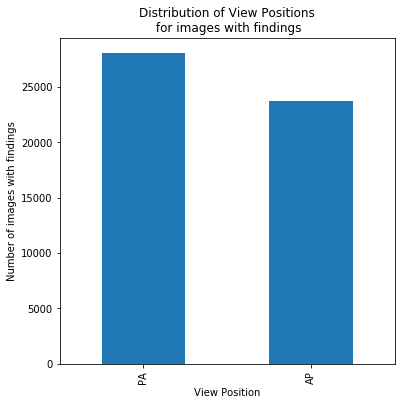

In [11]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df['Finding Labels'] != 'No Finding']['View Position'].value_counts().plot(kind='bar')
plt.title('Distribution of View Positions\n for images with findings')
plt.xlabel('View Position')
plt.ylabel('Number of images with findings')

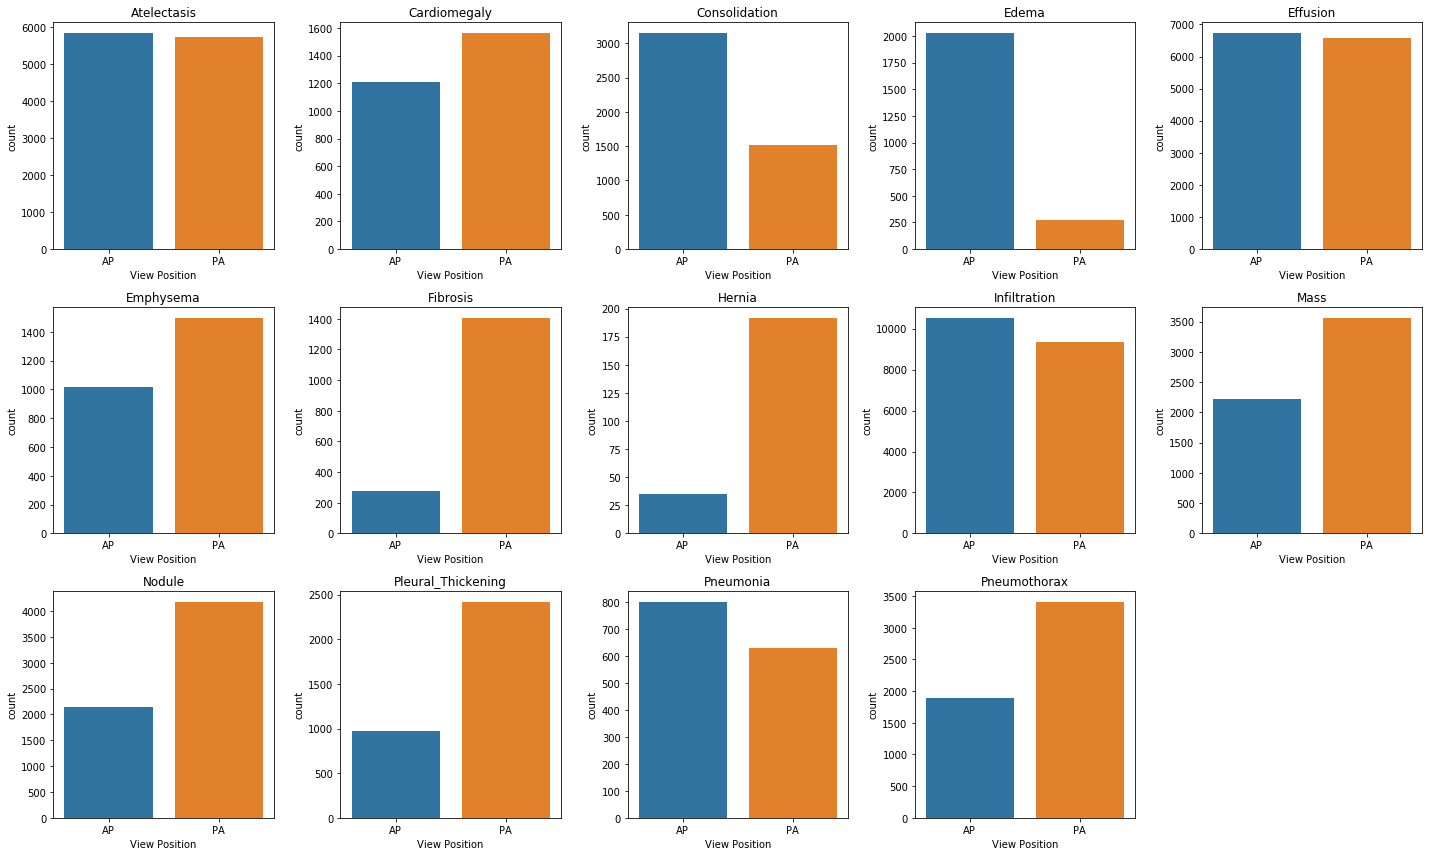

In [12]:
# Distribution of view positions for each disease
fig = plt.subplots(figsize = (20, 12))
for ind, label in enumerate(labels):
    plt.subplot(3, 5, ind+1)
    #ax = all_xray_df[all_xray_df[label] == 1.0]['Patient Gender'].value_counts().plot(kind='bar')
    plt.subplots_adjust(hspace = 1.0)
    ax = sns.countplot(x='View Position',data = all_xray_df[all_xray_df[label] == 1], order=['AP', 'PA'])
    plt.title(label)
    plt.tight_layout()

### The distribution of other diseases that are comorbid with pneumonia

In [13]:
all_xray_df[all_xray_df.Pneumonia==1][labels].sum()

Atelectasis            262.0
Cardiomegaly            41.0
Consolidation          123.0
Edema                  340.0
Effusion               269.0
Emphysema               23.0
Fibrosis                11.0
Hernia                   3.0
Infiltration           605.0
Mass                    71.0
Nodule                  70.0
Pleural_Thickening      48.0
Pneumonia             1431.0
Pneumothorax            41.0
dtype: float64

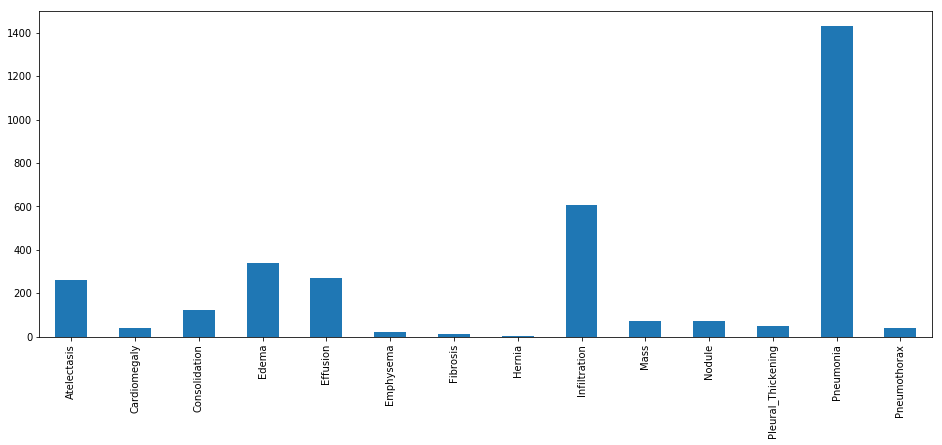

In [14]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1][labels].sum().plot(kind='bar')

This shows that infiltration, edema, effusion, atelectasis and consolidation are the top diseases that cormobid with pneumonia. At least these five diseases should have balanced representations in the training and validation datasets.

### Number of diseases per patient

In [15]:
diseases_per_patient = all_xray_df.groupby(['Patient ID'])[labels].sum()
diseases_per_patient['disease_count'] = diseases_per_patient.astype(bool).sum(axis=1)
diseases_per_patient.sample(3, random_state=random_state)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_count
Patient ID,,,,,,,,,,,,,,,
12681,8.0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,7
13125,3.0,3.0,1.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5
29707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Text(0,0.5,'Number of patients')

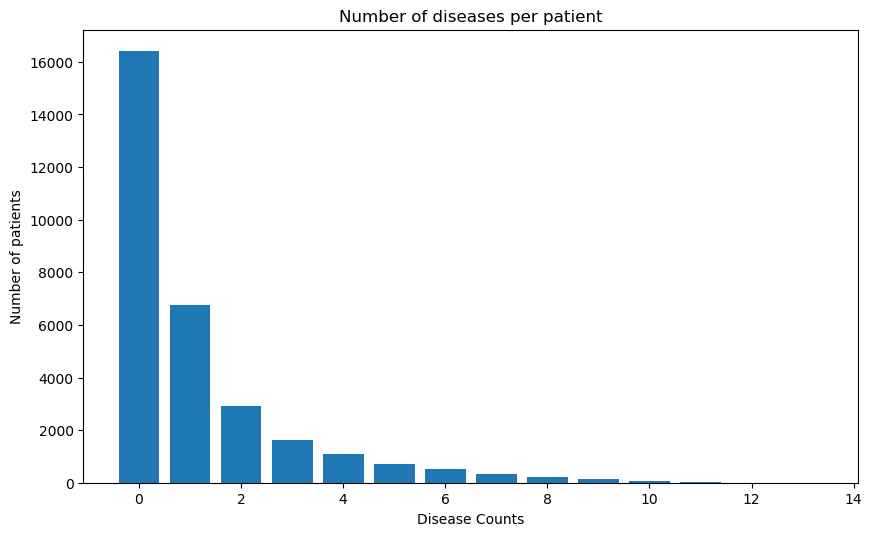

In [16]:
disease_count = diseases_per_patient['disease_count'].unique()
patient_count = [diseases_per_patient[diseases_per_patient['disease_count'] == item].count()[0]
                 for item in disease_count]
plt.figure(figsize = (10, 6), dpi = 100)
plt.bar(disease_count, patient_count)
plt.title('Number of diseases per patient')
plt.xlabel('Disease Counts')
plt.ylabel('Number of patients')

It is not clear from the plot if there are patients with more than 11 diseases co-existing. Better insights may be obtained by printing out the number of patients for each disease count.

In [17]:
for disease, patient in sorted(zip(disease_count, patient_count)):
    if disease <=1:
        print('%d patients have %d disease => %s of all patients'
              %(patient, disease, str(format(100*patient/np.sum(patient_count), '.3f')) + " %")
             )
    else:
        print('%d patients have %d diseases => %s of all patients'
              %(patient, disease, str(format(100*patient/np.sum(patient_count), '.3f')) + " %")
             )

16403 patients have 0 disease => 53.248 % of all patients
6742 patients have 1 disease => 21.886 % of all patients
2908 patients have 2 diseases => 9.440 % of all patients
1638 patients have 3 diseases => 5.317 % of all patients
1087 patients have 4 diseases => 3.529 % of all patients
707 patients have 5 diseases => 2.295 % of all patients
518 patients have 6 diseases => 1.682 % of all patients
335 patients have 7 diseases => 1.087 % of all patients
205 patients have 8 diseases => 0.665 % of all patients
139 patients have 9 diseases => 0.451 % of all patients
84 patients have 10 diseases => 0.273 % of all patients
28 patients have 11 diseases => 0.091 % of all patients
7 patients have 12 diseases => 0.023 % of all patients
4 patients have 13 diseases => 0.013 % of all patients


While more than half of the patients did not have any disease (no finding), some other patients suffer multiple diseases co-occuring. For example, 4 patients have 13 different diseases together.

Since more than 50% of the patients have zero disease, it may be necessary to drop some of the "no finding" images in order to create training and validation datasets.

In [ ]:
"""copied from https://knowledge.udacity.com/questions/196276"""
## Visualize the image
image = io.imread(i)
fig = plt.figure()
plt.imshow(image,cmap ='bone') 
## Intensity distribution
fig = plt.figure()
plt.hist(image.flatten(), bins = 128)
plt.show()

In [ ]:
"""copied from https://knowledge.udacity.com/questions/196276"""
# For Pneumonia case
pixel_array = np.array(pn_img.getdata())
plt.figure(figsize=(5,5))
plt.hist(pixel_array.ravel(), bins = 256)
plt.title('Image Pixel Intensity')
# Pixel average
mean_intensity = np.mean(pixel_array)
print("Pneumonia case mean intensity:", mean_intensity)
std_intensity = np.std(pixel_array)
print("Pneumonia case  std intensity:",std_intensity)
new_img = pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
plt.figure(figsize=(5,5))
plt.hist(new_img.ravel(), bins = 256)
plt.title('Normalized')

In [ ]:
paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(paths_img.get)

In [ ]:
hist = data_sample[data_sample["Finding Labels"].str.match('Pneumonia')]
data = []
for p in range(9):
    data.append(("pneumonia", hist.iloc[p]['path']))

In [ ]:
data_sample[data_sample["Finding Labels"] == "Pneumonia"].sample(3, random_state=random_state)["path"]

In [ ]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('pneumonia')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

This should work to display the pixel intensity for the pneumonia images.

From here you can go ahead and display the pixel level intensity for the other diseases like Cardiomegaly etc..

Hi Sathian

Explanation:

So the purpose of examining the pixel intensities is so that we can look at the graph and differentiate between diseases.

As I can see in the screenshot that you provided that you are examining the images without the disease labels but to extract meaningful conclusions we have to select a particular diseases that we want to examine and then compare it with the graph of other diseases.

Also the mean of the images for a particular disease will not have a exact value they will a range of values that's why need to examine at least 3 graphs per disease label to draw a conclusion.

How:

To extract the images for a particular disease let's sat Pneumonia you can use the following code:

sample_df[sample_df["Finding Labels"] == "Pneumonia"].sample(3)["Image Path"]

Note:- Here the variable sample_df is the name of the data frame while Image Path is the variable in which full path of the images are stored kindly change this variables according to your code.

Instructions:

1. You need to draw pixel intensity graph for all the 14 disease labels present in the dataset.

2. You need to draw pixel intensity graph for images with NO Finding label also.

3. You need to have at least 3 pixel intensity graph per disease.

4. Also make sure to normalise your graphs so that it is easy to compare them.

5. Look at the different disease labels and figure out which diseases have similar graph as that of Pneumonia.

6. You need to report such diseases in your EDA file.